### Import libraries

In [1]:
library(tidyverse)
library(corrplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

corrplot 0.92 loaded



### Configure defaults

In [2]:
options(repr.plot.width = 12, repr.plot.height = 7) # set plot size

### Read data
- The dataset is from database of a brazilian logistics company and it was collected during `60` days. The dataset has `13` columns of which `12` are predictive attributes and one is the target to be predicted. Columns are namely
    - Week_of_the_month : number with 5 possible values namely `1 (first)`, `2 (second)`, `3 (third)`, `4(fourth)`, `5 (fifth)`
    - Day_of_the_week : number with 5 possible values `2 (Monday)`, `3 (Tuesday)`, `4 (Wednesday)`, `5 (Thursday)`, `6 (Friday)`
    - Non_urgent_order : number
    - Urgent_order : number
    - Order_type_A : number
    - Order_type_B  : number
    - Order_type_C : number
    - Fiscal_sector_orders : number
    - Orders_from_the_traffic_controller_sector : number
    - Banking_orders_(1) : number
    - Banking_orders_(2) : number
    - Banking_orders_(3) : number
    - Target_(Total_orders) : number

In [3]:
data <- read_delim('~/Downloads/data-models/Lecture 9 - Linear regression/L8-demand/L8-demand.csv', delim = ';')
head(data)

Rows: 60 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl (13): Week of the month (first week, second, third, fourth or fifth week...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577
1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675
1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412
2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120
2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517
2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364


### Data conversion 
- Convert encoded categorical variables back to categories to let us understand data more easily

In [4]:
# rename first two columns to be easier to work with
colnames(data) = c('Week of month', 'Day of week', colnames(data)[3: dim(data)[2]])

transformed <- data %>% 
mutate(
    `Month week` = factor(
        case_when(
            `Week of month` == 1 ~ 'first',
            `Week of month` == 2 ~ 'second',
            `Week of month` == 3 ~ 'third',
            `Week of month` == 4 ~ 'fourth',
            `Week of month` == 5 ~ 'fifth',
        ),
        levels = c('first', 'second', 'third', 'fourth', 'fifth')
    ),
    `Week day` = factor(
        case_when(
            `Day of week` == 2 ~ 'Mon',
            `Day of week` == 3 ~ 'Tue',
            `Day of week` == 4 ~ 'Wed',
            `Day of week` == 5 ~ 'Thu',
            `Day of week` == 6 ~ 'Fri',
        ), 
        levels = c('Mon', 'Tue', 'Wed', 'Thu', 'Fri')
    )
)

head(transformed)

Week of month,Day of week,Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders),Month week,Week day
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,539.577,first,Wed
1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,224.675,first,Thu
1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.412,first,Fri
2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.120,second,Mon
2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,210.517,second,Tue
2,4,110.925,96.360,30.792,50.704,125.868,79.000,52042,8773,47522,24966,207.364,second,Wed


### Exploratory data analysis

In [5]:
summary(transformed[,3:dim(transformed)[2]])

 Non-urgent order  Urgent order     Order type A     Order type B   
 Min.   : 43.65   Min.   : 77.37   Min.   : 21.83   Min.   : 25.12  
 1st Qu.:125.35   1st Qu.:100.89   1st Qu.: 39.46   1st Qu.: 74.92  
 Median :151.06   Median :113.11   Median : 47.17   Median : 99.48  
 Mean   :172.55   Mean   :118.92   Mean   : 52.11   Mean   :109.23  
 3rd Qu.:194.61   3rd Qu.:132.11   3rd Qu.: 58.46   3rd Qu.:132.17  
 Max.   :435.30   Max.   :223.27   Max.   :118.18   Max.   :267.34  
  Order type C    Fiscal sector orders
 Min.   : 74.37   Min.   :  0.000     
 1st Qu.:113.63   1st Qu.:  1.243     
 Median :127.99   Median :  7.832     
 Mean   :139.53   Mean   : 77.396     
 3rd Qu.:160.11   3rd Qu.: 20.361     
 Max.   :302.45   Max.   :865.000     
 Orders from the traffic controller sector Banking orders (1)
 Min.   :11992                             Min.   :  3452    
 1st Qu.:34994                             1st Qu.: 20130    
 Median :44312                             Median : 32528 

**Observation**
- There is greater amount of data collected for middle of month than start or end of month
- There exist extreme values (outliers) that are larger from majority in the columns namely `Non-urgent order`, `Urgent orders`, `Fiscal sector orders`, `Order type A, B and C`, `Banking orders`, `Total orders`
- `Orders from the traffic controller sector` is the only numeric column which has no outliers
- `Orders from the traffic controller sector`, `Banking orders (1)`, `Banking orders (2)`, `Banking orders (3)` have high values

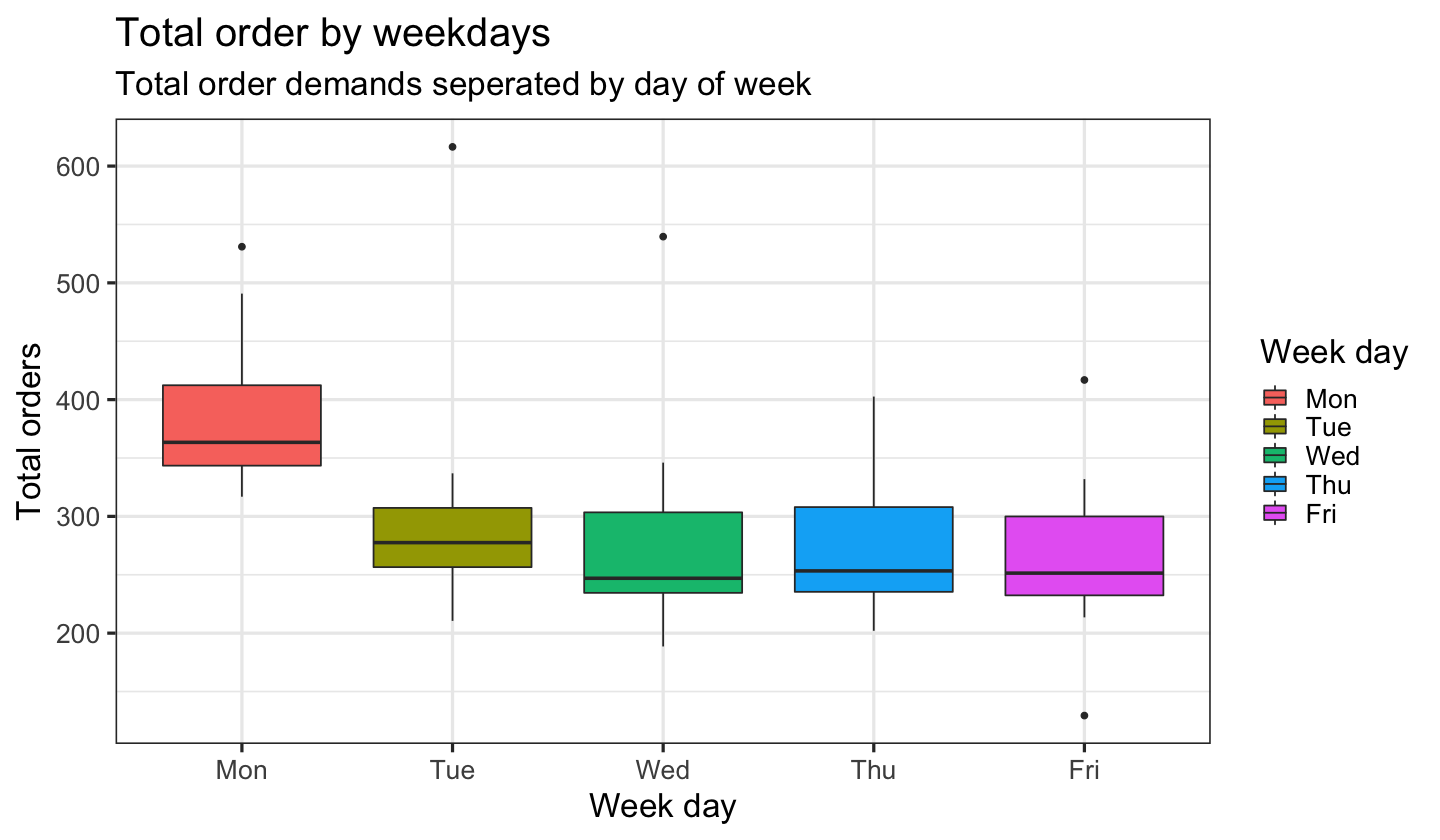

In [6]:
ggplot(transformed) + 
geom_boxplot(mapping = aes(x = `Week day`, y = `Target (Total orders)`, fill = `Week day`)) +
ylab('Total orders') +
ggtitle('Total order by weekdays', subtitle = 'Total order demands seperated by day of week') +
theme_bw(base_size = 20)

**Observation**
- From the visualization and after looking at the numbers, it was revealed that `75 percent` of total order demand on weekdays except Mondays is not greater than `310`. On the other hand, the minimum total order demand on Monday was more than `315`. Therefore, on `Mondays` total order demands tend to be higher than the rest of the weekdays

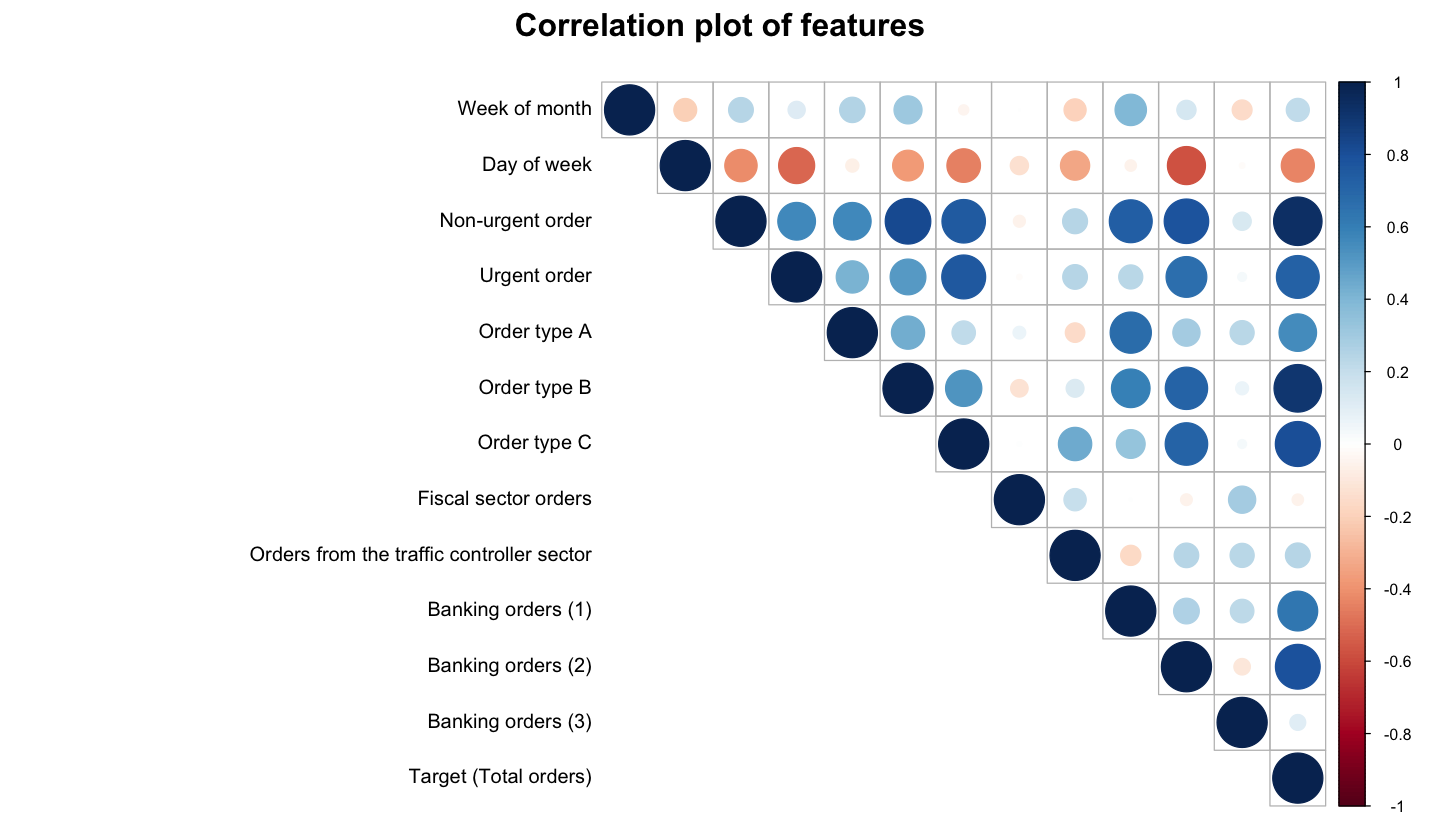

In [7]:
data %>% 
select(where(is.numeric)) %>% 
cor() %>%
corrplot(
    type = "upper", 
    tl.col = "black",
    tl.cex = 1,
    tl.pos = 'l',
    mar = c(0, 0, 2, 0),
    title = 'Correlation plot of features',
    cex.main = 1.6,
)

**Observation**
- The correlation plot tells that most of the columns has positive relationship with `Target (Total orders)`
- `Day of week` is the only column which has negative relationship with `Target (Total orders)`

[1] 0.9345178

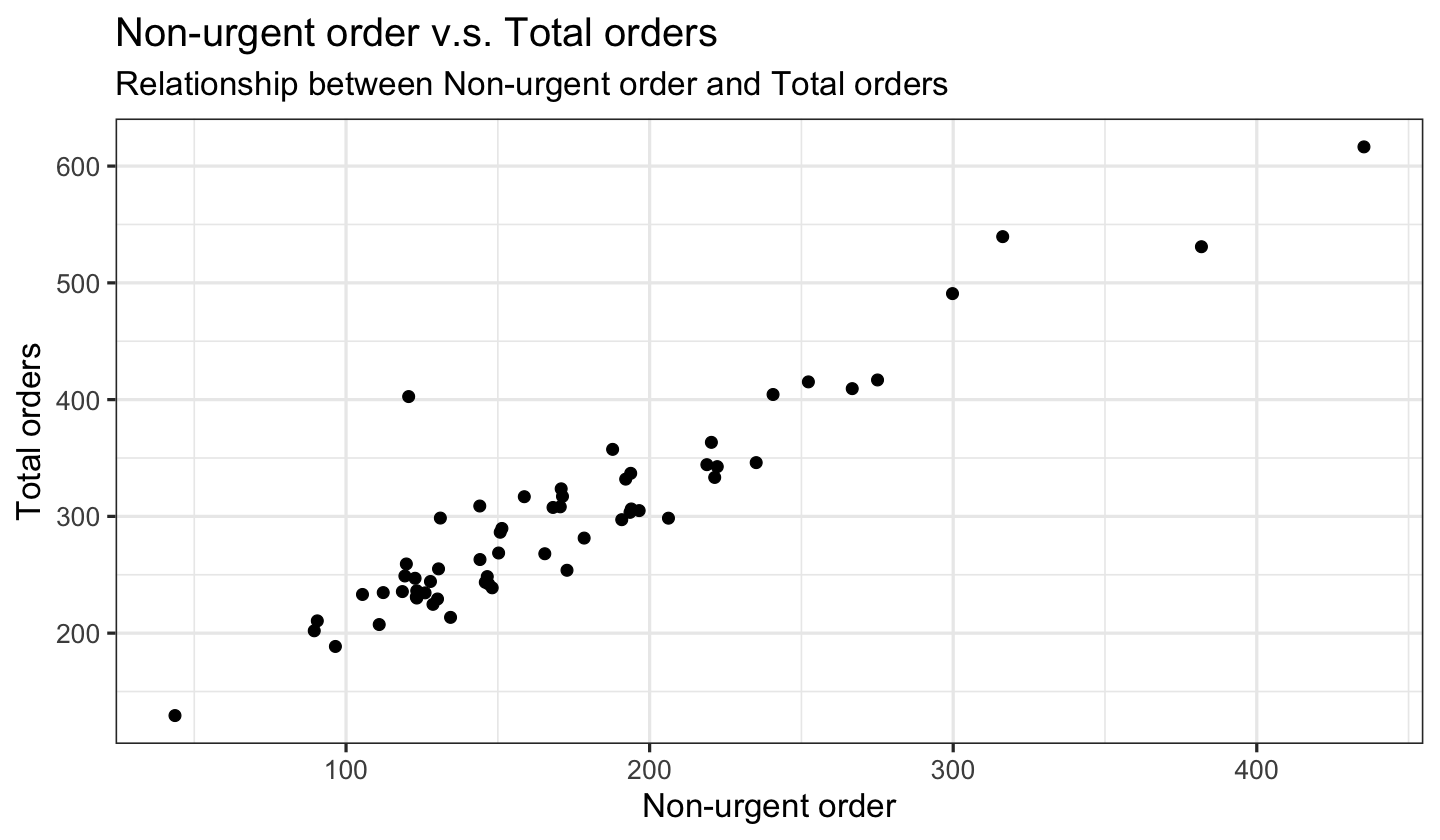

In [8]:
ggplot(transformed) +
geom_point(mapping = aes(x = `Non-urgent order`, y = `Target (Total orders)`), size = 3) +
ylab('Total orders') + 
ggtitle('Non-urgent order v.s. Total orders', subtitle = 'Relationship between Non-urgent order and Total orders') +
theme_bw(base_size = 20)

cor(transformed$`Non-urgent order`, transformed$`Target (Total orders)`)

**Observation**
- The amount of `Non-urgent order` has a very strong positive correlation (strongest among the features) with `Target (Total orders)`. 
- Thus, a high `Non-urgent order` is very likely to be associated with high `Total orders` and same pattern applies for low value of both orders

[1] -0.05211609

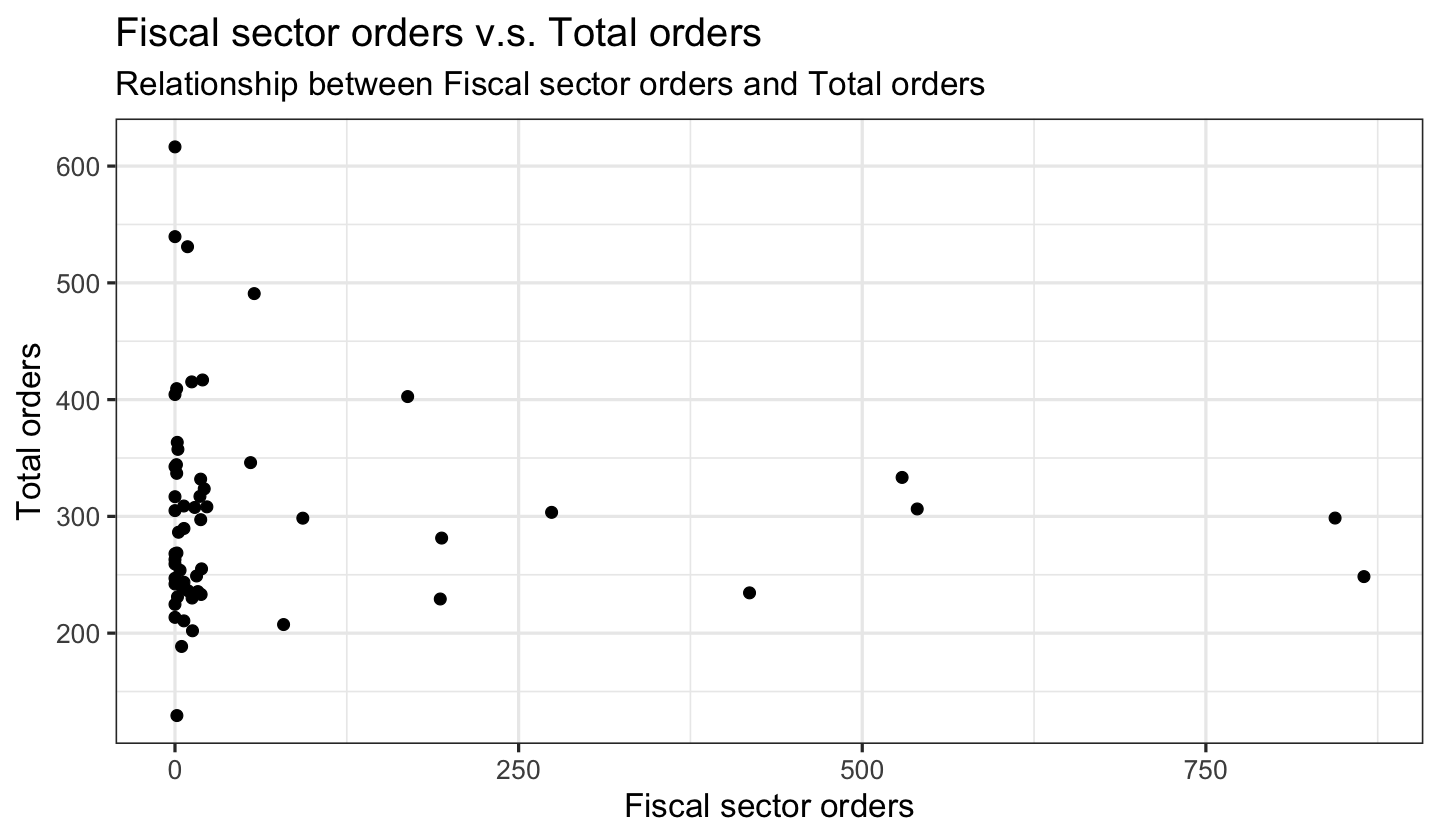

In [9]:
ggplot(transformed) +
geom_point(mapping = aes(x = `Fiscal sector orders`, y = `Target (Total orders)`), size = 3) +
ylab('Total orders') + 
ggtitle(
    'Fiscal sector orders v.s. Total orders', 
    subtitle = 'Relationship between Fiscal sector orders and Total orders'
) +
theme_bw(base_size = 20)

cor(transformed$`Fiscal sector orders`, transformed$`Target (Total orders)`)

**Observation**
- `Fiscal sector orders` variable and the `Target (Total orders)` have weak negative correlation with each other
- Hence, there is still some tendency to see high `Target (Total orders)` associated with low `Fiscal sector orders` and the other way around

### Preprocessing
- Transform features to be similar scale by centering and scaling

In [11]:
scaled <- NULL
all_cols <- colnames(transformed)

# loop through numeric columns
for (col in all_cols[1 : (length(all_cols) - 3)]){
    cname <- paste(col, 'scaled', sep = ' ')
    scaled[[col]] = scale(transformed[[col]])
#     scaled[[col]] = (transformed[[col]] - min(transformed[[col]])) / (max(transformed[[col]]) - min(transformed[[col]]))
}

scaled$`Target (Total orders)` = transformed$`Target (Total orders)`

scaled <- data.frame(scaled)
colnames(scaled) <- gsub("\\.", "_", colnames(scaled))

head(scaled, n = 5)

,Week_of_month,Day_of_week,Non_urgent_order,Urgent_order,Order_type_A,Order_type_B,Order_type_C,Fiscal_sector_orders,Orders_from_the_traffic_controller_sector,Banking_orders__1_,Banking_orders__2_,Banking_orders__3_,Target__Total_orders_
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.00,0.50,0.6961673,1.00000000,0.4122073,0.6211827,1.00000000,0.000000000,0.8960187,0.20024534,1.00000000,0.1075272,539.577
2,0.00,0.75,0.2169829,0.12797209,0.1684656,0.1276211,0.24644417,0.000000000,0.4755269,0.08667703,0.42470930,0.0000000,224.675
3,0.00,1.00,0.0000000,0.04800581,0.0000000,0.0000000,0.03546625,0.001602312,0.0000000,0.00000000,0.02845349,0.1098549,129.412
4,0.25,0.00,0.3259161,0.34473163,0.2046247,0.3640083,0.38545046,0.020989595,0.6353128,0.14610057,0.30606395,0.1623942,317.120
5,0.25,0.25,0.1197003,0.24780842,0.1645321,0.1300198,0.18348270,0.007467052,0.6112747,0.07821073,0.00000000,0.1901149,210.517


### Simple linear regression

In [12]:
m1 <- lm(Target__Total_orders_ ~ Non_urgent_order, data = scaled)
summary(m1)


Call:
lm(formula = Target__Total_orders_ ~ Non_urgent_order, data = scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.301 -21.302  -4.259  12.069 164.290 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       145.581      8.806   16.53   <2e-16 ***
Non_urgent_order  471.830     23.596   20.00   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 32.16 on 58 degrees of freedom
Multiple R-squared:  0.8733,	Adjusted R-squared:  0.8711 
F-statistic: 399.9 on 1 and 58 DF,  p-value: < 2.2e-16


**Observation**
- `Non_urgent_order`, the feature that have strongest correlation with target, was used for simple linear regression. 
- Per one standard deviation increase in `Non_urgent_order`, the `Total_orders` demand rise by `83.735`. Moreover, `Non_urgent_order` alone can very well predict the `Total_orders` demand with `Adjusted R-squared` of `0.8711`

In [13]:
m2 <- lm(Target__Total_orders_ ~ Non_urgent_order + Urgent_order, data = scaled)
summary(m2)


Call:
lm(formula = Target__Total_orders_ ~ Non_urgent_order + Urgent_order, 
    data = scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.700  -9.123  -6.669   3.006 159.158 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       132.779      6.694  19.837  < 2e-16 ***
Non_urgent_order  387.257     20.941  18.493  < 2e-16 ***
Urgent_order      142.695     19.955   7.151 1.78e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 23.56 on 57 degrees of freedom
Multiple R-squared:  0.9332,	Adjusted R-squared:  0.9309 
F-statistic: 398.3 on 2 and 57 DF,  p-value: < 2.2e-16


- Including `Urgent_order` variable added more relevant information about target to linear regression model. The `Adjusted R-squared` of model considering both non-urgent and urgent orders is `0.9309` which is `~6 percent` increase of `Adjusted R-squared` from previous model
- 

In [50]:
summary(lm(Target__Total_orders_ ~ Non_urgent_order + Order_type_A, data = scaled))


Call:
lm(formula = Target__Total_orders_ ~ Non_urgent_order + Order_type_A, 
    data = scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-50.225 -19.915  -2.918  11.731 165.415 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       300.873      4.159  72.345   <2e-16 ***
Non_urgent_order   81.157      5.068  16.014   <2e-16 ***
Order_type_A        4.592      5.068   0.906    0.369    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 32.21 on 57 degrees of freedom
Multiple R-squared:  0.8751,	Adjusted R-squared:  0.8707 
F-statistic: 199.7 on 2 and 57 DF,  p-value: < 2.2e-16


In [52]:
summary(lm(Target__Total_orders_ ~ Non_urgent_order + Urgent_order + Order_type_B + Order_type_C + Banking_orders__2_, data = scaled))


Call:
lm(formula = Target__Total_orders_ ~ Non_urgent_order + Urgent_order + 
    Order_type_B + Order_type_C + Banking_orders__2_, data = scaled)

Residuals:
    Min      1Q  Median      3Q     Max 
-19.082  -6.789  -1.019   5.479  33.893 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         300.873      1.365 220.485  < 2e-16 ***
Non_urgent_order     31.325      3.555   8.813 4.92e-12 ***
Urgent_order         16.689      2.353   7.091 2.93e-09 ***
Order_type_B         41.821      2.763  15.134  < 2e-16 ***
Order_type_C         19.768      2.992   6.608 1.78e-08 ***
Banking_orders__2_   -8.232      2.525  -3.260  0.00193 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.57 on 54 degrees of freedom
Multiple R-squared:  0.9873,	Adjusted R-squared:  0.9861 
F-statistic: 837.1 on 5 and 54 DF,  p-value: < 2.2e-16


In [11]:

# library(broom)
# library(mosaic)

# data %>% 
# gather(key = 'column', value = 'value', 3:13) %>%
# ggplot(mapping = aes(x = column, y = value)) +
# theme_bw(base_size = 20) +
# geom_boxplot()

# transformed %>%
# select(c(`Order type A`, `Order type B`, `Order type C`, `Week day`)) %>%
# gather(key = 'type', value = 'demand', 1:3) %>%
# ggplot() + 
# geom_boxplot(mapping = aes(x = `Week day`, y = demand, fill = type)) +
# theme_bw(base_size = 20)

# ggplot(transformed) + 
# geom_bar(mapping = aes(x = `Week day`, fill = `Week day`)) +
# theme_bw(base_size = 20)

# **Observation**
# - Amount of data collected for Wendesday is greatest whilst least no. of demand observations belong to Monday. No. of  records for the remaining week days are even

# ggplot(transformed) + 
# geom_boxplot(mapping = aes(y = `Orders from the traffic controller sector`)) +
# theme_bw(base_size = 20)

# transformed %>% 
# group_by(`Week day`) %>% 
# summarize(
#     min = min(`Target (Total orders)`),
#     q1 = quantile(`Target (Total orders)`, 0.25), 
#     median = median(`Target (Total orders)`), 
#     q3 = quantile(`Target (Total orders)`, 0.75),
# )

#     strsplit(col, ' ')[[1]] %>% paste(collapse =  '_') %>% paste('scaled', sep = '_')
#     scaled <- scaled %>% add_column(cname = scale(transformed[[col]]))

# geom_vline(color = 'red', xintercept = mean(transformed$`Fiscal sector orders`)) +
# geom_hline(color = 'blue', yintercept = mean(transformed$`Target (Total orders)`)) +

# transformed %>% 
# mutate(
#     target_lt = `Target (Total orders)` < mean(`Target (Total orders)`),
#     input_lt = `Fiscal sector orders` < mean(`Fiscal sector orders`),
# ) %>%
# group_by(target_lt, input_lt) %>%
# summarise(n = n())

# cov(x = transformed$`Fiscal sector orders`,y = transformed$`Target (Total orders)`)

# - It may first seem hard to conclude the direction of relationship from plot beacuse at low value of `Fiscal sector orders`, for example value `0`, the `Total orderd` was sometimes low and sometimes high.

# in the scatter plot as the `Total orders` vary from `~130` to `~600` there was both increase and decrease in `Fiscal sector orders`. Similarly when the `Fiscal sector orders` rises, `Total orders` did not go far from `300`

# summary(lm(`Target (Total orders)` ~ `Non-urgent order`, data = transformed))

# Also, There are strong correlation between some of the explanatory vairables which will require us to select features instead of using all of them for linear regression

# ggplot(transformed) +
# geom_point(mapping = aes(x = `Banking orders (2)`, y = `Non-urgent order`), size = 3) +
# ggtitle(
#     'Banking orders (2) v.s. Non-urgent order', 
#     subtitle = 'Relationship between Banking orders (2) and Non-urgent order'
# ) +
# theme_bw(base_size = 20)

# cor(transformed$`Non-urgent order`, transformed$`Banking orders (2)`)

# - Multi-collinearity is when independent variables have high correlation with each other and can be used to predict one another
# - Multi-collinearity issue might make multiple linear regression not give valid results about influence of individual predictors on target, or about which predictors are redundant with respect to others. Example of collinear features in this dataset are `Non-urgent order` and `Banking orders (2)`